In [1]:
%matplotlib inline

import os, sys
import numpy as np
import matplotlib.pyplot as pl

from math import sqrt
from IPython.display import display, Image

from ecdsa.ecdsa import ellipticcurve as ec

## <span style="color:darkorange;">Elliptic Curve definition</span>

An elliptic curve over real numbers may be defined as the set of points (x,y) which satisfy an elliptic curve equation of the form $y^2 = x^3 + ax + b$ where $x$, $y$, $a$ and $b$ are real numbers.
Each choice of the numbers $a$ and $b$ yields a different elliptic curve.

If $4a^3 + 27b^2\neq0$ then the elliptic curve $y^2 = x^3 + ax + b$ can be used to form a group. An elliptic curve group over real numbers consists of the points on the corresponding elliptic curve, together with a special point O called the point at infinity.

Below are some examples plotted.

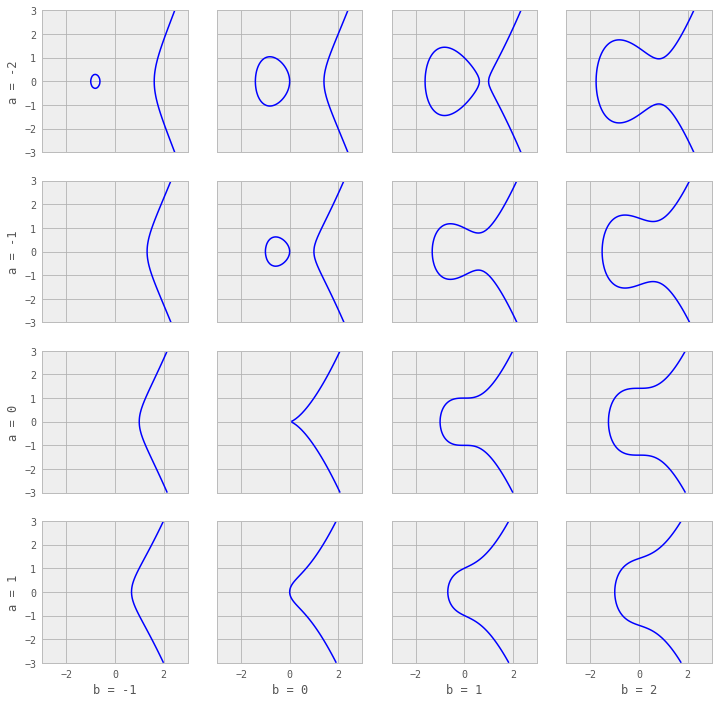

In [2]:
ma = 3
Y, X = np.mgrid[-ma:ma:100j, -ma:ma:100j]

a_rng = [-2, -1, 0, 1]
b_rng = [-1, 0, 1, 2]

fig, axes2d = pl.subplots(nrows=4, ncols=4, sharex=True, sharey=True, figsize=(12, 12))

for i, row in enumerate(axes2d):
    for j, ax in enumerate(row):
        a = a_rng[i]
        b = b_rng[j]
        ax.contour(X, Y, Y**2 - (X**3 + a*X+b), levels=[0], colors='blue')
        ax.set_xlim(-ma, ma)
        ax.set_ylim(-ma, ma)
        if i == len(axes2d) - 1:
            ax.set_xlabel('b = {0}'.format(b))
        if j == 0:
            ax.set_ylabel('a = {0}'.format(a))

## <span style="color:darkorange;">Elliptic Curve Addition: A geometric approach</span>

+ Elliptic curve groups are additive groups.  
P+Q=R is the additive property defined geometrically.  
The negative of a point P is its reflection in the x-axis.  
Notice that for each point P on an elliptic curve, the point -P is also on the curve. 

+ #### Adding distinct points P and Q.  
Suppose that P and Q are two distinct points on an elliptic curve, and that P is not -Q. To add points P and Q, a line is drawn through the two points. This line will intersect the elliptic curve in exactly one more point, call -R. The point -R is reflected in the x-axis to the point R. The law for addition in an elliptic curve group is P+Q=R.  

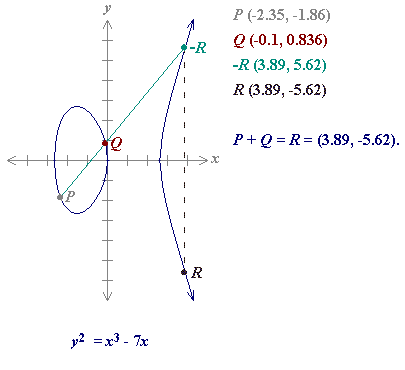

In [3]:
Image(filename=os.path.join('img', 'ec_add_distinct_P_and_Q.png')) 

+ #### Adding points P and -P.  
The line through P and -P is a vertical line which does not intersect the elliptic curve at a third point; thus the points P and -P cannot be added as previously. It is for this reason that the elliptic curve group includes the point at infinity O. By definition, P+(-P)=O. As a result of this equation, P+O=P in the elliptic curve group . O is called the additive identity of the elliptic curve group. 

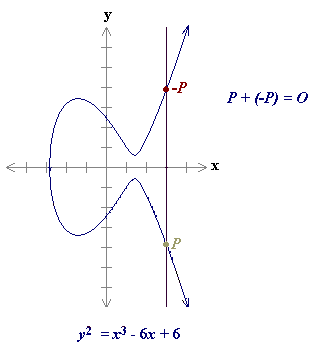

In [4]:
Image(filename=os.path.join('img', 'ec_add_P_to_minus_P.png')) 

+ #### Adding P to itself (doubling)  
To add a point P to itself, a tangent line to the curve is drawn at the point P. If P(y) is not 0, then the tangent line intersects the elliptic curve at exactly one other point, -R. -R is reflected in the x-axis to R. This operation is called doubling the point P; the law for doubling a point on an elliptic curve group is defined by: P+P=2P=R

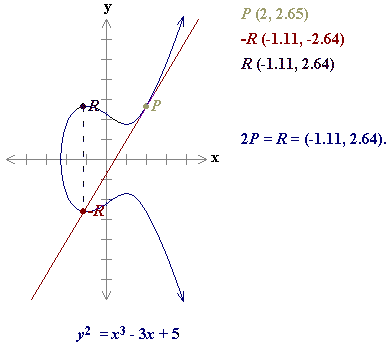

In [5]:
Image(filename=os.path.join('img', 'ec_double_P.png')) 

+ #### Doubling P if P(y)=0  
The tangent from P is always vertical if P(y)=0.
If a point P is such that P(y)=0, then the tangent line to the elliptic curve at P is vertical and does not intersect the elliptic curve at any other point. By definition, 2P=O for such a point P. If one wanted to find 3P in this situation, one can add 2P+P. This becomes P+O=P Thus 3P=P. Thus 3P=P, 4P=O, 5P=P, 6P=O, 7P=P, etc. 

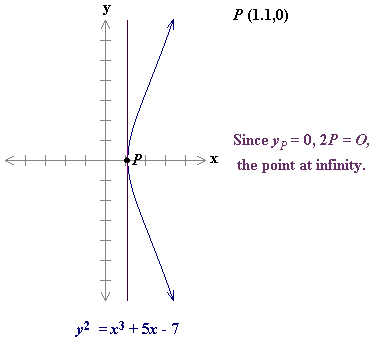

In [6]:
Image(filename=os.path.join('img', 'ec_double_P_if_vertical_tangent.png')) 

+ #### A simple summary that contains all 4 cases

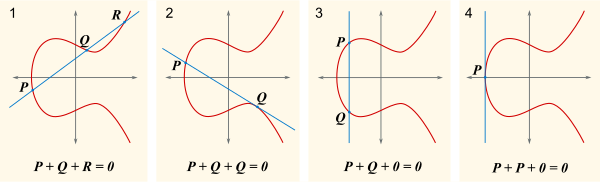

In [7]:
Image(filename=os.path.join('img', 'ECClines.png')) 

### Add and plot functions

In [8]:
# EC equation
def f(x, a, b):
    return x**3 + a*x + b

# EC addition
def ec_add(P, Q, a, b):
    (px, py) = P
    (qx, qy) = Q
    
    # p is o
    if (px==None and py==None):
        return (qx, qy, None, None)
    
    # q is o
    if (qx==None and qy==None):
        return (px, py, None, None)
    
    # p=q and py=qy=0
    if ((px==qx) and (py==qy) and (abs(py)<1e-4)):
        return (None, None, float('inf'), None)

    # (p and q have same x) but (py or qy <> 0)
    if ((px==qx) and (py==-qy)):
        return (None, None, float('inf'), None)
    
    # p + p
    if ((px==qx) and (py==qy)):
        s = (3 * px**2 + a) / (2 * py)
        
    # p + q
    else:
        # slope of 
        s = (py - qy) / (px - qx)
    
    rx = s**2 - px - qx
    ry = s * (px - rx) - py
    
    # origin of connecting line
    u = py - s * px
    
    return (rx, ry, s, u)

In [9]:
# find y>0 for x so that (x, y) is on EC
def ec_y(x, s, a, b):
    if (f(x, a, b)<0): return None
    return s * sqrt(f(x, a, b))


def plot_real_EC(px, py, qx, qy, rx, ry, s, u, a, b):
    ma = 5
    Y, X = np.mgrid[-ma:ma:100j, -ma:ma:100j]
    x = X[0]

    fig = pl.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    ax.contour(X, Y, Y**2 - f(X, a, b), levels=[0], colors='blue')

    os = 0.7
    fs = 16

    if not(px==None and py==None):
        ax.plot(px, py, 'o', color='blue')
        ax.annotate('P', xy=(px-os, py+os), fontsize=fs)
    else:
        ax.annotate('O', xy=(-ma+os, -ma+os), fontsize=fs)

    if not(qx==None and qy==None):
        ax.plot(qx, qy, 'o', color='blue')
        ax.annotate('Q', xy=(qx-os, qy-os), fontsize=fs)
    else:
        ax.annotate('O', xy=(-ma+os, -ma+os), fontsize=fs)
    
    if (s==float('inf')):
        ax.axvline(x=px, ymin=-ma, ymax=ma, color='orange')
    elif s:
        ax.plot(x, s*x+u, color='orange')
        
        
    if rx:
        ax.plot(rx, ry, 'ro')
        ax.annotate('R', xy=(rx-os, ry-os), fontsize=fs)

        if s:
            ax.plot(rx, -ry, 'yo')
            ax.annotate("R'", xy=(rx-os, -ry-os), fontsize=fs)

            ax.axvline(x=rx, ymin=-ma, ymax=ma, color='orange', linestyle='--')

    else:
        ax.annotate('O', xy=(-ma+os, -ma+os), fontsize=fs, color='red')

    ax.set_xlim(left=-ma, right=ma)
    ax.set_ylim(bottom=-ma, top=ma)
    pl.show()
    
    
def plot_real_EC_simple(a, b, ma=5.0):
    Y, X = np.mgrid[-ma:ma:100j, -ma:ma:100j]
    x = X[0]

    fig = pl.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    ax.contour(X, Y, Y**2 - f(X, a, b), levels=[0], colors='blue')

    ax.set_xlim(left=-ma, right=ma)
    ax.set_ylim(bottom=-ma, top=ma)
    pl.show()

### Elliptic Curve Definition

In [10]:
a = -3.0
b = 5.0

### General case: R = P + Q

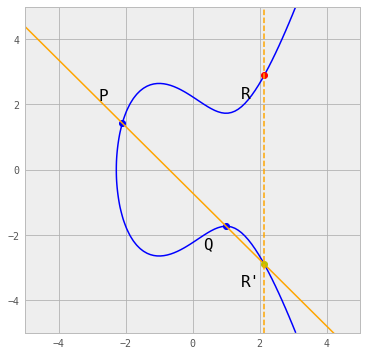

In [11]:
px, ps = -2.1, 1
qx, qs = 1.0, -1

py = ec_y(px, ps, a, b)
qy = ec_y(qx, qs, a, b)
if not(py and qy):
    print('Error: P or Q is not on the EC')

rx, ry, s, u = ec_add((px, py), (qx, qy), a, b)

plot_real_EC(px, py, qx, qy, rx, ry, s, u, a, b)

### Special case: R = P + P = 2P

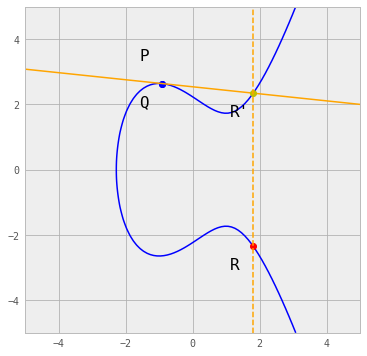

In [12]:
px, ps = -0.9, 1

py = ec_y(px, ps, a, b)
if not(py):
    print('Error: P is not on the EC')

rx, ry, s, u = ec_add((px, py), (px, py), a, b)

plot_real_EC(px, py, px, py, rx, ry, s, u, a, b)

### Special case: R = P + P = O

[-2.27901879+0.j          1.13950939+0.94627954j  1.13950939-0.94627954j]
P is the intersection of the EC with axis y=0
None None inf None


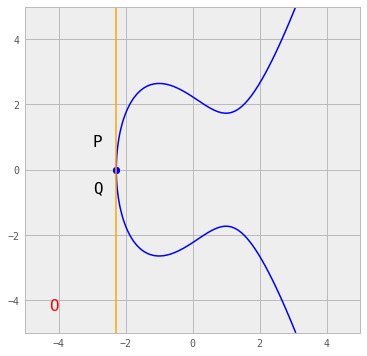

In [13]:
r = np.roots([1, 0, a, b])
print(r)

px, py = r[0].real, 0
print('P is the intersection of the EC with axis y=0')

rx, ry, s, u = ec_add((px, py), (px, py), a, b)

print(rx, ry, s, u)

plot_real_EC(px, py, px, py, rx, ry, s, u, a, b)

### Special case: R = P + Q = O

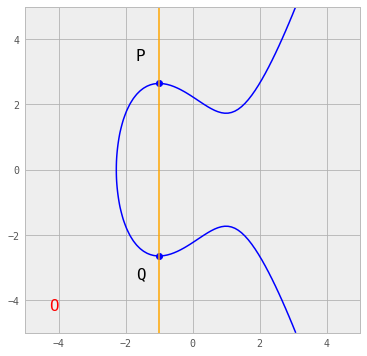

In [14]:
px, ps = -1.0, 1
qx, qs = -1.0, -1

py = ec_y(px, ps, a, b)
qy = ec_y(qx, qs, a, b)
if not(py and qy):
    print('Error: P or Q is not on the EC')

rx, ry, s, u = ec_add((px, py), (qx, qy), a, b)

plot_real_EC(px, py, qx, qy, rx, ry, s, u, a, b)

### Special case: R = P + O = P

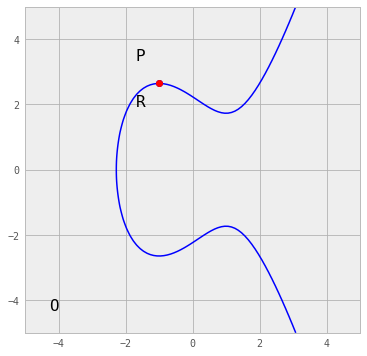

In [15]:
px, ps = -1.0, 1
qx, qs = None, None

py = ec_y(px, ps, a, b)
qy = None
if not(py):
    print('Error: P is not on the EC')

rx, ry, s, u = ec_add((px, py), (qx, qy), a, b)

plot_real_EC(px, py, qx, qy, rx, ry, s, u, a, b)

## <span style="color:darkorange;">Elliptic Curve over finite field $\mathbb{F}_p$: An Algebraic approach</span>

Calculations over the real numbers are slow and inaccurate due to round-off error. Cryptographic applications require fast and precise arithmetic; thus elliptic curve groups over the finite fields of $\mathbb{F}_p$ and $\mathbb{F}_{2m}$ are used in practice. 

Recall that the field $\mathbb{F}_p$ uses the numbers from 0 to p-1, and computations end by taking the remainder on division by p. For example, in $\mathbb{F}_{23}$ the field is composed of integers from 0 to 22, and any operation within this field will result in an integer also between 0 and 22. 

An elliptic curve with the underlying field of $\mathbb{F}_p$ can formed by choosing the variables a and b within the field of $\mathbb{F}_p$. The elliptic curve includes all points (x,y) which satisfy the elliptic curve equation modulo p (where x and y are numbers in $\mathbb{F}_p$). 

For example: $y^2 mod p = x^3 + ax + b mod p$ has an underlying field of $\mathbb{F}_p$ if a and b are in $\mathbb{F}_p$. 

If $x^3 + ax + b$ contains no repeating factors (or, equivalently, if $4a^3 + 27b^2 mod\ p \neq 0$), then the elliptic curve can be used to form a group. An elliptic curve group over Fp consists of the points on the corresponding elliptic curve, together with a special point O called the point at infinity. There are finitely many points on such an elliptic curve. 


+ Adding distinct points P and Q  
When $P=(Px,Py)$ and $Q=(Qx,Qy)$ are not negative of each other, then $P+Q=R$ where  
  + $s = (Py-Qy)/(Px-Qx)$  
  + $Rx = s^2 - Px - Qx$
  + $Ry = -Py + s(Px - Rx)$   
  + Note that $s$ is the slope of the line through P and Q. 


+ Doubling Point P  
When $Py \neq  0$, then $2P = R$ where 
  + $s = (3Px^2 + a) / (2Py)$ 
  + $Rx = s2 - 2Px$
  + $Ry = -Py + s(Px - Rx)$
  + Recall that a is one of the parameters chosen with the elliptic curve and that s is the tangent on the point P. 



## <span style="color:darkorange;">Exploring some small Elliptic Curves over finite fields</span>
+ #### Go through curve from starting point (generator) by repeatedly adding it to itself 
+ #### Compare generators and identify strongest

### Plotting functions

In [16]:
def ec_over_ff(p, a, b):
    c = ec.CurveFp(p, a, b)

    pts = []
    for i in range(p):
        for j in range(p):
            if c.contains_point(i, j):
                pts.append(ec.Point(c, i, j))
    
    paths = {}
    for g in pts:
        #print g
        ng = g
        path = []
        while ng not in path:
            path.append(ng)
            #print ng
            ng = ng+g
        
        k = g.x(), g.y()
        paths[k] = path
    
    return c, pts, paths


def to_2d(pts, paths):
    ppts = np.array([[pt.x(), pt.y()] for pt in pts])
    ppaths = {(k[0], k[1]): np.array([[pt.x(), pt.y()] for pt in v]) for k, v in paths.items()}
    porder = {k: len(v) for k, v in ppaths.items()}
    
    return ppts, ppaths, porder


def plot_ec_over_ff(c, ppts, ppaths, g):
    gg = tuple(g)
    ppath = ppaths[gg]
    
    fig = pl.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)    
    
    ax.scatter(ppts[:, 0], ppts[:, 1], s=80, color='blue', zorder=5)
    ax.scatter(ppath[0, 0], ppath[0, 1], s=30, color='red', zorder=6)
    ax.plot(ppath[:, 0], ppath[:, 1], zorder=1)

    if [None, None] in ppath: ax.text(-1, -1, r'$\infty$', fontsize=20, color = '#0000ff') 
    
    ax.set_xlim(-0.5, c.p()-1+0.5)
    ax.set_ylim(-0.5, c.p()-1+0.5)
    ax.set_title('Elliptic Curve $y^2=x^3+{}x+{}$ over Finite Field({}) - Generator ({}, {})'.format(c.a(), c.b(), c.p(),
                                                                                                     gg[0], gg[1]))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    if c.p()<50:
        ax.xaxis.set_ticks(np.arange(0, c.p(), 1))
        ax.yaxis.set_ticks(np.arange(0, c.p(), 1))
        
    
def plot_order(c, porder):
    d = list(porder.values())

    fig = pl.figure(figsize=(15, 5))
    ax = fig.add_subplot(111)
    w = 0.3
    h = ax.hist(d, np.arange(min(d)-0.5, max(d)+1.5), width=2*w)
    ax.set_xlim(min(d)-0.5, max(d)+0.5)
    ax.set_title('Distribution of the order of generators'.format(c.a(), c.b(), c.p()))
    ax.set_xlabel('Order')
    ax.set_ylabel('Nb of generators')
    if max(d)<50:
        ax.xaxis.set_ticks(np.arange(1, max(d)+1, 1))
    
    return h


### Elliptic Curve $y^2=x^3+7 \ mod\ 17$

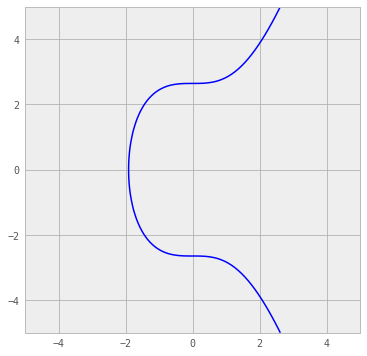

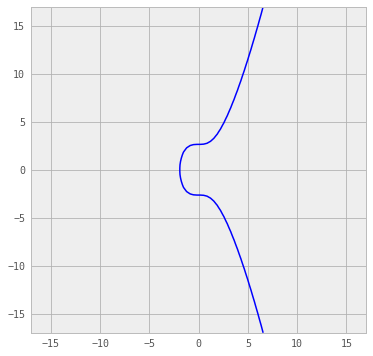

In [17]:
a, b = 0.0, 7.0
plot_real_EC_simple(a, b, 5.0)
plot_real_EC_simple(a, b, 17.0)

Equation y^2 = x^3 + 0 x + 7 mod 17

Nb of points = 17

Strongest generators
[(6, 6), (6, 11), (10, 2), (10, 15), (15, 4), (15, 13)]

Weakest generators
[(3, 0), (5, 8), (5, 9)]


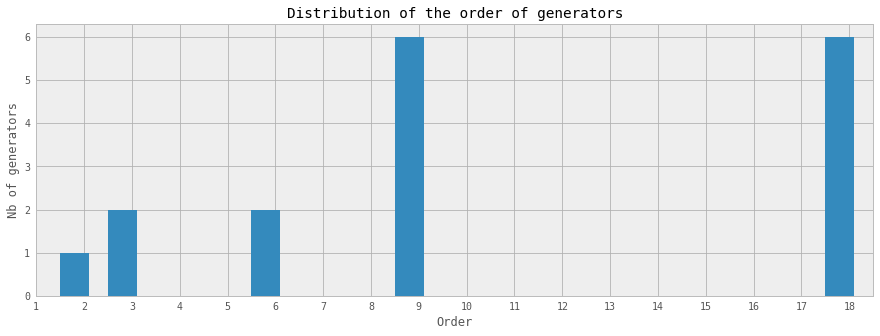

In [18]:
c, pts, paths = ec_over_ff(17, 0, 7)
ppts, ppaths, porder = to_2d(pts, paths)

plot_order(c, porder)

print('Equation y^2 = x^3 + {} x + {} mod {}'.format(c.a(), c.b(), c.p()))

print('\nNb of points = {}'.format(len(ppts)))

print('\nStrongest generators')
print([k  for k, v in porder.items() if v>15])

print('\nWeakest generators')
print([k  for k, v in porder.items() if v<5])

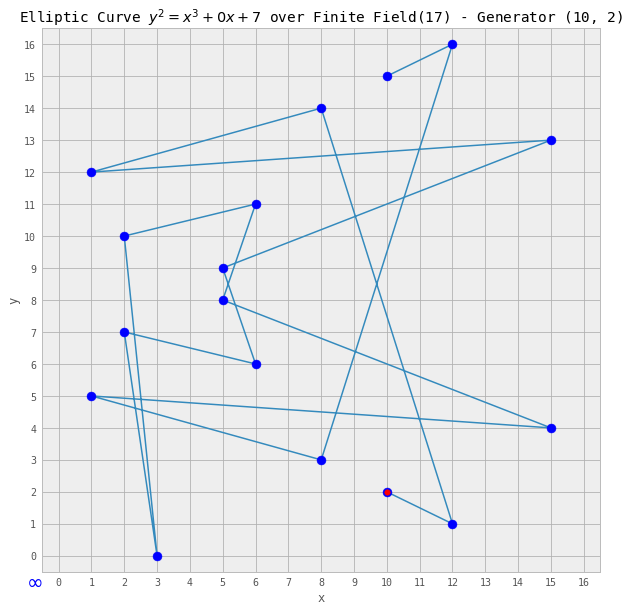

In [19]:
plot_ec_over_ff(c, ppts, ppaths, [10, 2])

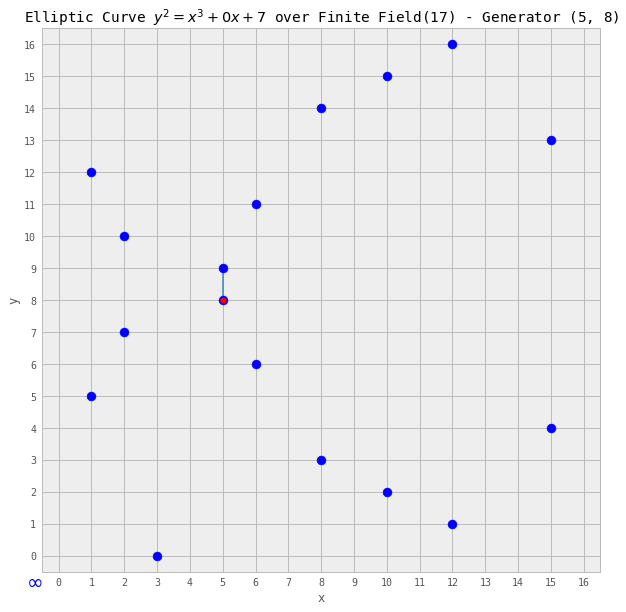

In [20]:
plot_ec_over_ff(c, ppts, ppaths, [5, 8])

### Elliptic Curve $y^2=x^3+x  \ mod\ 23$

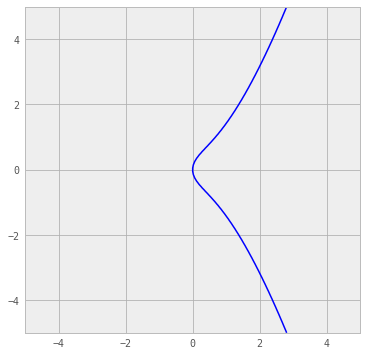

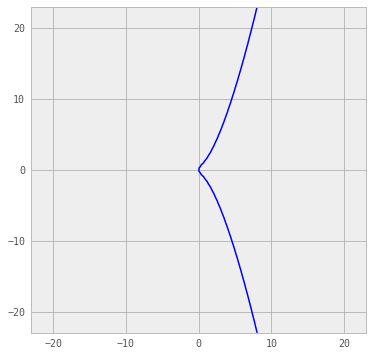

In [21]:
a, b = 1.0, 0.0
plot_real_EC_simple(a, b, 5.0)
plot_real_EC_simple(a, b, 23.0)

Equation y^2 = x^3 + 1 x + 0 mod 23

Nb of points = 23

Strongest generators
[(11, 10), (11, 13), (17, 10), (17, 13), (19, 1), (19, 22), (21, 6), (21, 17)]

Weakest generators
[(0, 0), (1, 5), (1, 18), (18, 10), (18, 13)]


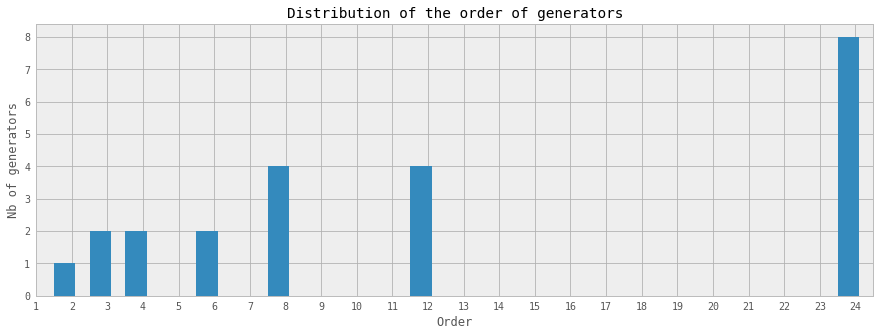

In [22]:
c, pts, paths = ec_over_ff(23, 1, 0)
ppts, ppaths, porder = to_2d(pts, paths)

plot_order(c, porder)

print('Equation y^2 = x^3 + {} x + {} mod {}'.format(c.a(), c.b(), c.p()))

print('\nNb of points = {}'.format(len(ppts)))

print('\nStrongest generators')
print([k  for k, v in porder.items() if v>15])

print('\nWeakest generators')
print([k  for k, v in porder.items() if v<5])

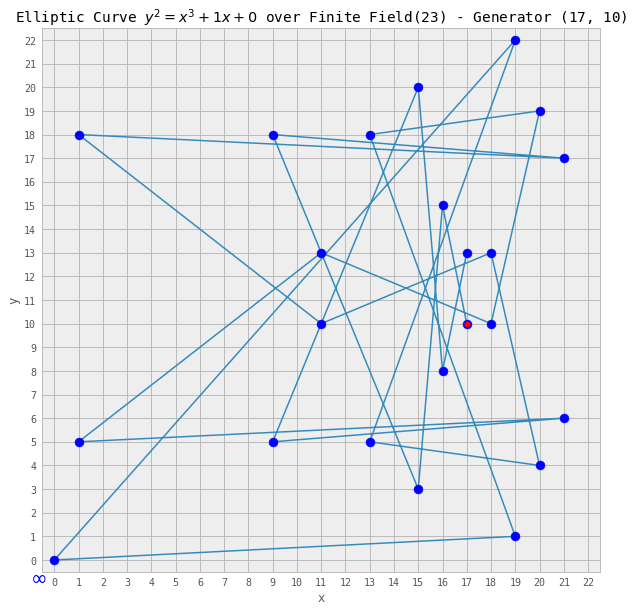

In [23]:
plot_ec_over_ff(c, ppts, ppaths, [17, 10])

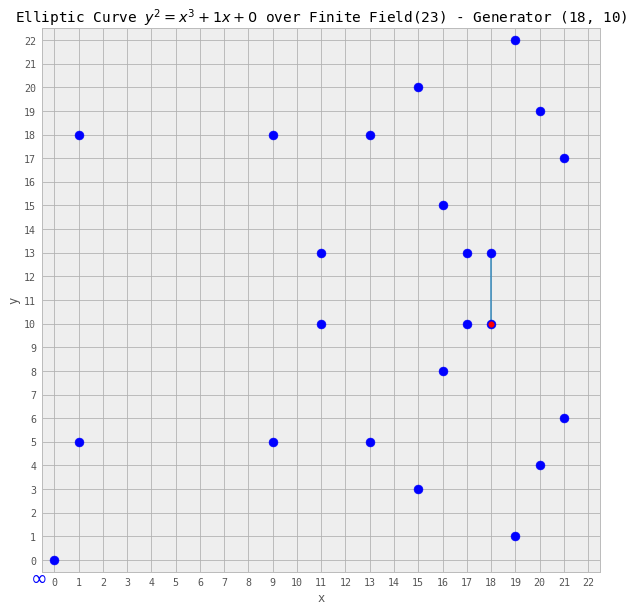

In [24]:
plot_ec_over_ff(c, ppts, ppaths, [18, 10])

### Elliptic Curve $y^2=x^3+2x+3 \ mod\ 263$

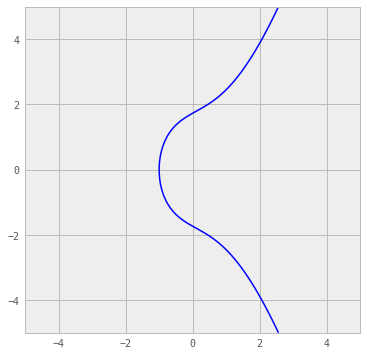

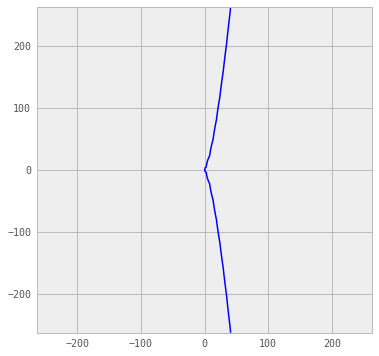

In [25]:
a, b = 2.0, 3.0
plot_real_EC_simple(a, b, 5.0)
plot_real_EC_simple(a, b, 263.0)

Equation y^2 = x^3 + 2 x + 3 mod 263

Nb of points = 269

Strongest generators
[(4, 115), (4, 148), (13, 124), (13, 139), (14, 113), (14, 150), (19, 59), (19, 204), (37, 51), (37, 212), (41, 10), (41, 253), (55, 3), (55, 260), (66, 31), (66, 232), (75, 121), (75, 142), (76, 45), (76, 218), (111, 16), (111, 247), (114, 104), (114, 159), (119, 126), (119, 137), (129, 9), (129, 254), (133, 125), (133, 138), (153, 103), (153, 160), (166, 3), (166, 260), (169, 92), (169, 171), (174, 119), (174, 144), (179, 14), (179, 249), (193, 128), (193, 135), (198, 95), (198, 168), (200, 39), (200, 224), (216, 51), (216, 212), (218, 7), (218, 256), (225, 40), (225, 223), (226, 78), (226, 185), (228, 106), (228, 157), (229, 9), (229, 254), (230, 89), (230, 174), (231, 109), (231, 154), (238, 125), (238, 138), (240, 64), (240, 199), (244, 101), (244, 162), (250, 102), (250, 161), (256, 31), (256, 232)]

Weakest generators
[(144, 35), (144, 228), (262, 0)]


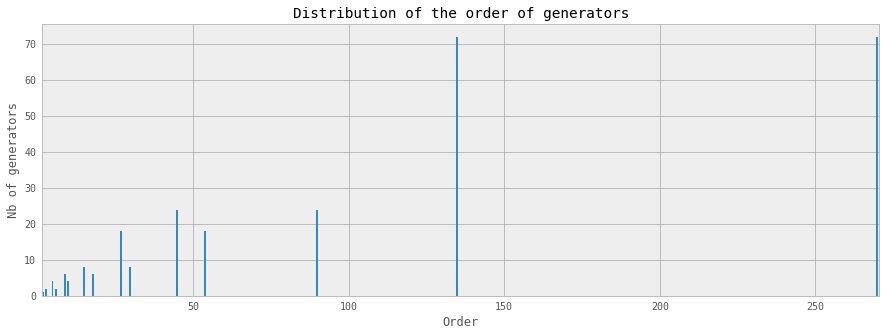

In [26]:
c, pts, paths = ec_over_ff(263, 2, 3)
ppts, ppaths, porder = to_2d(pts, paths)

h = plot_order(c , porder)

print('Equation y^2 = x^3 + {} x + {} mod {}'.format(c.a(), c.b(), c.p()))

print('\nNb of points = {}'.format(len(ppts)))

print('\nStrongest generators')
print([k  for k, v in porder.items() if v>260])

print('\nWeakest generators')
print([k  for k, v in porder.items() if v<5])

In [27]:
print('Focus on order distribution\n')
[[k, int(b)] for k, b in enumerate(h[0]) if b>0]

Focus on order distribution



[[0, 1],
 [1, 2],
 [3, 4],
 [4, 2],
 [7, 6],
 [8, 4],
 [13, 8],
 [16, 6],
 [25, 18],
 [28, 8],
 [43, 24],
 [52, 18],
 [88, 24],
 [133, 72],
 [268, 72]]

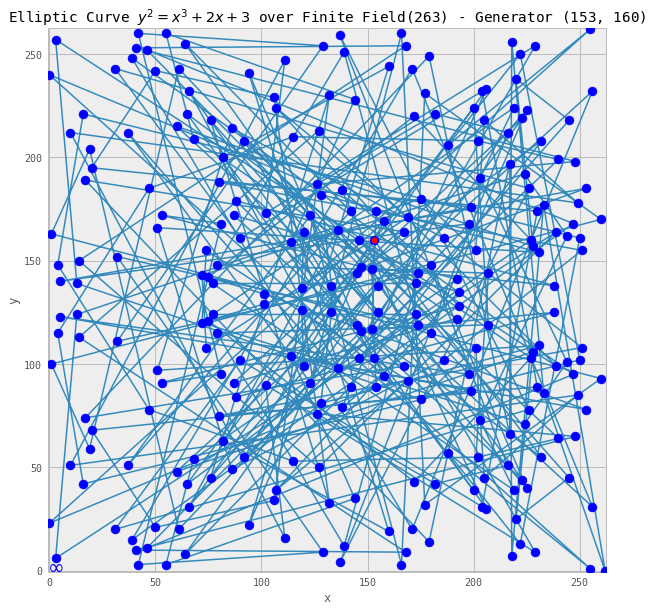

In [28]:
plot_ec_over_ff(c, ppts, ppaths, [153, 160])

## Test Zone

In [29]:
c, pts, paths = ec_over_ff(17, 0, 7)
ppts, ppaths, porder = to_2d(pts, paths)

print(ec.Point(c, 3, 0)+ec.Point(c, 3, 0))

infinity
